# MMTL-Plant_disease_detection

## Introduction
The agricultural sector faces significant challenges due to the prevalence of plant diseases, which can lead to reduced crop yields and economic losses. Early and accurate disease detection is crucial for mitigating these impacts. Traditionally, plant disease detection relies on visual inspection, which is subjective, labor-intensive, and often inaccurate. While recent advancements in deep learning have enabled image-based disease detection, relying solely on visual data may limit diagnostic accuracy, especially in complex scenarios influenced by environmental or soil conditions.

To address this limitation, this project proposes a multimodal transfer learning system that leverages three complementary data sources: plant leaf images, soil characteristics, and weather data. By combining the strengths of these modalities, the system aims to enhance diagnostic accuracy and generalizability across different environments and plant species.

The proposed model incorporates a pre-trained convolutional neural network (CNN) for extracting features from leaf images and a feed-forward neural network for processing tabular data representing soil and weather conditions. These subnetworks are fused into a unified decision-making framework, leveraging transfer learning techniques to achieve state-of-the-art performance even with limited domain-specific datasets.

This approach not only enhances detection accuracy but also provides a scalable solution for real-world agricultural applications, empowering farmers and agronomists to make data-driven decisions for disease management and sustainable farming practices.

## Objective
To develop a robust multimodal transfer learning system for detecting plant diseases by integrating information from plant leaf images, soil characteristics, and weather data, thereby enabling accurate and timely disease diagnosis for improved crop management and agricultural productivity.

### Setting up workspace

In [ ]:
!pip install kaggle

Importing libraries

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image
import numpy as np
import pandas as pd
import psutil
import matplotlib.pyplot as plt
import tensorflow as tf
#from memory_profiler import memory_usage
import matplotlib.image as mping
from keras import models, layers
import joblib
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,  ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
import csv

## CNN Subnetwork

Importing dataset

In [ ]:
kaggle_credentials = json.load(open('/content/kaggle.json'))

In [ ]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

In [ ]:
!kaggle datasets download abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.01G/2.04G [00:02<00:00, 714MB/s]
100% 2.04G/2.04G [00:02<00:00, 874MB/s]


In [ ]:
!dir

kaggle.json  plantvillage-dataset.zip  sample_data


In [ ]:
with ZipFile('/content/plantvillage-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
print(os.listdir('/content/plantvillage dataset'))


print(len(os.listdir(r'/content/plantvillage dataset/color')))
print(os.listdir(r'/content/plantvillage dataset/color')[:5])

print(len(os.listdir(r'/content/plantvillage dataset/grayscale')))
print(os.listdir(r'/content/plantvillage dataset/grayscale')[:5])

print(len(os.listdir(r'/content/plantvillage dataset/segmented')))
print(os.listdir(r'/content/plantvillage dataset/segmented')[:5])

['segmented', 'color', 'grayscale']
38
['Tomato___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Grape___Black_rot']
38
['Tomato___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Grape___Black_rot']
38
['Tomato___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Grape___Black_rot']


In [ ]:
base_dir = '/content/plantvillage dataset/color'

In [ ]:
image_path = '/content/plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'

(256, 256, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

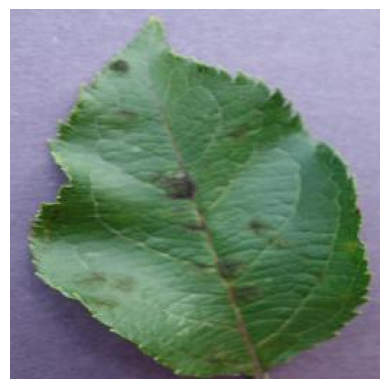

In [ ]:
img = mping.imread(image_path)
print(img.shape)

plt.imshow(img)
plt.axis('off')
plt.show

In [ ]:
img  = mping.imread(image_path)
print(img)

[[[167 163 196]
  [166 162 195]
  [165 161 194]
  ...
  [185 182 211]
  [183 180 209]
  [181 178 207]]

 [[170 166 199]
  [169 165 198]
  [168 164 197]
  ...
  [186 183 212]
  [184 181 210]
  [183 180 209]]

 [[170 166 199]
  [169 165 198]
  [168 164 197]
  ...
  [188 185 214]
  [186 183 212]
  [185 182 211]]

 ...

 [[100  90 124]
  [102  92 126]
  [104  94 128]
  ...
  [126 110 137]
  [126 110 137]
  [126 110 137]]

 [[101  91 125]
  [102  92 126]
  [103  93 127]
  ...
  [122 106 133]
  [123 107 134]
  [123 107 134]]

 [[104  94 128]
  [103  93 127]
  [102  92 126]
  ...
  [121 105 132]
  [122 106 133]
  [123 107 134]]]


In [ ]:
img_size = 224
batch_size = 32

In [ ]:
no_epochs = 3
lr = 1e-3
class_mode = 'categorical'
shuffle = True

### Dataset Generation

Image Data Generator

In [ ]:
Data_Gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [ ]:
train_generator = Data_Gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    subset='training',
    class_mode='categorical',
    shuffle=True,
)

Found 43456 images belonging to 38 classes.


In [ ]:
validation_generator = Data_Gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


In [ ]:
test_generator = Data_Gen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
    class_mode='categorical',
    shuffle = False
)

Found 10849 images belonging to 38 classes.


#### Defining Class indices (Y: Plant diseases)

In [ ]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [ ]:
unique, counts = np.unique(train_generator.classes, return_counts=True)
class_counts = dict(zip(unique, counts))

In [ ]:
class_counts

{np.int32(0): np.int64(504),
 np.int32(1): np.int64(497),
 np.int32(2): np.int64(220),
 np.int32(3): np.int64(1316),
 np.int32(4): np.int64(1202),
 np.int32(5): np.int64(842),
 np.int32(6): np.int64(684),
 np.int32(7): np.int64(411),
 np.int32(8): np.int64(954),
 np.int32(9): np.int64(788),
 np.int32(10): np.int64(930),
 np.int32(11): np.int64(944),
 np.int32(12): np.int64(1107),
 np.int32(13): np.int64(861),
 np.int32(14): np.int64(339),
 np.int32(15): np.int64(4406),
 np.int32(16): np.int64(1838),
 np.int32(17): np.int64(288),
 np.int32(18): np.int64(798),
 np.int32(19): np.int64(1183),
 np.int32(20): np.int64(800),
 np.int32(21): np.int64(800),
 np.int32(22): np.int64(122),
 np.int32(23): np.int64(297),
 np.int32(24): np.int64(4072),
 np.int32(25): np.int64(1468),
 np.int32(26): np.int64(888),
 np.int32(27): np.int64(365),
 np.int32(28): np.int64(1702),
 np.int32(29): np.int64(800),
 np.int32(30): np.int64(1528),
 np.int32(31): np.int64(762),
 np.int32(32): np.int64(1417),
 np.int32

In [ ]:
unique_val, counts_val = np.unique(validation_generator.classes, return_counts=True)
val_class_counts = dict(zip(unique_val, counts_val))

In [ ]:
val_class_counts

{np.int32(0): np.int64(126),
 np.int32(1): np.int64(124),
 np.int32(2): np.int64(55),
 np.int32(3): np.int64(329),
 np.int32(4): np.int64(300),
 np.int32(5): np.int64(210),
 np.int32(6): np.int64(170),
 np.int32(7): np.int64(102),
 np.int32(8): np.int64(238),
 np.int32(9): np.int64(197),
 np.int32(10): np.int64(232),
 np.int32(11): np.int64(236),
 np.int32(12): np.int64(276),
 np.int32(13): np.int64(215),
 np.int32(14): np.int64(84),
 np.int32(15): np.int64(1101),
 np.int32(16): np.int64(459),
 np.int32(17): np.int64(72),
 np.int32(18): np.int64(199),
 np.int32(19): np.int64(295),
 np.int32(20): np.int64(200),
 np.int32(21): np.int64(200),
 np.int32(22): np.int64(30),
 np.int32(23): np.int64(74),
 np.int32(24): np.int64(1018),
 np.int32(25): np.int64(367),
 np.int32(26): np.int64(221),
 np.int32(27): np.int64(91),
 np.int32(28): np.int64(425),
 np.int32(29): np.int64(200),
 np.int32(30): np.int64(381),
 np.int32(31): np.int64(190),
 np.int32(32): np.int64(354),
 np.int32(33): np.int64(

In [ ]:
unique_test, counts_test = np.unique(test_generator.classes, return_counts=True)
test_class_counts = dict(zip(unique_test, counts_test))

In [ ]:
test_class_counts

{np.int32(0): np.int64(126),
 np.int32(1): np.int64(124),
 np.int32(2): np.int64(55),
 np.int32(3): np.int64(329),
 np.int32(4): np.int64(300),
 np.int32(5): np.int64(210),
 np.int32(6): np.int64(170),
 np.int32(7): np.int64(102),
 np.int32(8): np.int64(238),
 np.int32(9): np.int64(197),
 np.int32(10): np.int64(232),
 np.int32(11): np.int64(236),
 np.int32(12): np.int64(276),
 np.int32(13): np.int64(215),
 np.int32(14): np.int64(84),
 np.int32(15): np.int64(1101),
 np.int32(16): np.int64(459),
 np.int32(17): np.int64(72),
 np.int32(18): np.int64(199),
 np.int32(19): np.int64(295),
 np.int32(20): np.int64(200),
 np.int32(21): np.int64(200),
 np.int32(22): np.int64(30),
 np.int32(23): np.int64(74),
 np.int32(24): np.int64(1018),
 np.int32(25): np.int64(367),
 np.int32(26): np.int64(221),
 np.int32(27): np.int64(91),
 np.int32(28): np.int64(425),
 np.int32(29): np.int64(200),
 np.int32(30): np.int64(381),
 np.int32(31): np.int64(190),
 np.int32(32): np.int64(354),
 np.int32(33): np.int64(

In [ ]:
def get_counts(generator):
    # Reverse the class_indices mapping: numeric -> class name
    inv_map = {v: k for k, v in generator.class_indices.items()}
    # generator.classes is an array of integer labels for each image
    unique, counts = np.unique(generator.classes, return_counts=True)
    # Create dictionary: class name -> count
    return {inv_map[k]: v for k, v in zip(unique, counts)}

# Compute counts for each generator
train_counts = get_counts(train_generator)
val_counts   = get_counts(validation_generator)
test_counts  = get_counts(test_generator)

# Combine all class names (assumes same set of classes in each generator)
all_classes = sorted(set(list(train_counts.keys()) + list(val_counts.keys()) + list(test_counts.keys())))

# Create a DataFrame with a column for each dataset
df = pd.DataFrame(index=all_classes)
df['Train'] = [train_counts.get(cls, 0) for cls in all_classes]
df['Validation'] = [val_counts.get(cls, 0) for cls in all_classes]
df['Test'] = [test_counts.get(cls, 0) for cls in all_classes]

print("Image Counts Per Class:")
print(df.to_string())


Image Counts Per Class:
                                                    Train  Validation  Test
Apple___Apple_scab                                    504         126   126
Apple___Black_rot                                     497         124   124
Apple___Cedar_apple_rust                              220          55    55
Apple___healthy                                      1316         329   329
Blueberry___healthy                                  1202         300   300
Cherry_(including_sour)___Powdery_mildew              842         210   210
Cherry_(including_sour)___healthy                     684         170   170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot    411         102   102
Corn_(maize)___Common_rust_                           954         238   238
Corn_(maize)___Northern_Leaf_Blight                   788         197   197
Corn_(maize)___healthy                                930         232   232
Grape___Black_rot                                     944       

### ML models


In [ ]:
def extract_and_flatten(generator):
    total = generator.samples
    h, w, c = generator.image_shape
    X_all = np.zeros((total, h * w * c), dtype=np.float32)
    # Since batch_labels is one-hot, store it temporarily as float32
    y_all = np.zeros((total,), dtype=np.int32)

    i = 0
    for batch_imgs, batch_labels in generator:
        bs = batch_imgs.shape[0]
        flat = batch_imgs.reshape(bs, -1)
        X_all[i : i + bs, :] = flat

        # Convert (bs, num_classes) one-hot → (bs,) integer labels
        int_labels = np.argmax(batch_labels, axis=1)
        y_all[i : i + bs] = int_labels

        i += bs
        if i >= total:
            break
    return X_all, y_all

X_train, y_train = extract_and_flatten(train_generator)
X_valid, y_valid = extract_and_flatten(validation_generator)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import time

# Method 1: Principal Component Analysis
print("Applying PCA to reduce dimensions...")
start_time = time.time()

# Reduce to 1000 components (you can experiment with this number)
pca = PCA(n_components=1000, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)

print(f"PCA completed in {time.time() - start_time:.2f} seconds")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
print(f"Original shape: {X_train.shape} -> Reduced shape: {X_train_pca.shape}")

Applying PCA to reduce dimensions...
PCA completed in 189.34 seconds
Explained variance ratio: 0.859
Original shape: (43456, 150528) -> Reduced shape: (43456, 1000)


In [ ]:
class_names = list(train_generator.class_indices.keys())

In [ ]:
def get_system_stats():
    """Return system CPU%, system RAM used (GB), and disk I/O."""
    cpu = psutil.cpu_percent(interval=None)
    mem = psutil.virtual_memory()
    disk = psutil.disk_io_counters()
    return cpu, (mem.total - mem.available) / 1e9, disk.read_bytes, disk.write_bytes

def get_process_memory_gb():
    """Return current process RSS memory usage in GB."""
    proc = psutil.Process(os.getpid())
    return proc.memory_info().rss / (1024 ** 3)

def count_model_params(model):
    total = 0
    if hasattr(model, 'coef_'):
        total += model.coef_.size
    if hasattr(model, 'feature_importances_'):
        total += model.feature_importances_.size
    if hasattr(model, 'estimators_'):
        for est in model.estimators_:
            total += count_model_params(est)
    return total

def train_and_collect(name, model, X_tr, y_tr, X_val=None, y_val=None, class_names=None):
    # baseline system & process stats
    cpu_pre, ram_sys_pre, dio_read_pre, dio_write_pre = get_system_stats()
    proc_mem_pre = get_process_memory_gb()
    samples_train = X_tr.shape[0]

    # train
    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    cpu_post_train, ram_sys_post_train, dio_read_post, dio_write_post = get_system_stats()
    proc_mem_post_train = get_process_memory_gb()

    # estimate peak as max of pre/train
    peak_rss_gb = max(proc_mem_pre, proc_mem_post_train)

    # save model size and params
    tmp_file = f"{name}_model.joblib"
    joblib.dump(model, tmp_file)
    model_size_mb = os.path.getsize(tmp_file) / 1e6
    os.remove(tmp_file)
    n_params = count_model_params(model)

    # inference & metrics
    inf_time = accuracy = precision = recall = f1 = None
    rss_after_inf = None
    throughput_train = samples_train / train_time if train_time else None

    if X_val is not None and y_val is not None:
        t1 = time.time()
        preds = model.predict(X_val)
        inf_time = time.time() - t1
        rss_after_inf = get_process_memory_gb()
        throughput_inf = X_val.shape[0] / inf_time if inf_time else None

        accuracy = accuracy_score(y_val, preds)
        precision = precision_score(y_val, preds, average='weighted', zero_division=0)
        recall = recall_score(y_val, preds, average='weighted', zero_division=0)
        f1 = f1_score(y_val, preds, average='weighted', zero_division=0)

        df_report = pd.DataFrame(classification_report(
            y_val, preds, target_names=class_names, output_dict=True
        )).transpose()
        df_report.to_csv(f"{name}_classification_report.csv")
    else:
        throughput_inf = None

    return {
        'model': name,
        'cpu_pre_%': cpu_pre,
        'ram_sys_pre_GB': ram_sys_pre,
        'disk_read_pre_MB': dio_read_pre/1e6,
        'disk_write_pre_MB': dio_write_pre/1e6,
        'cpu_post_train_%': cpu_post_train,
        'ram_sys_post_train_GB': ram_sys_post_train,
        'disk_read_post_train_MB': dio_read_post/1e6,
        'disk_write_post_train_MB': dio_write_post/1e6,
        'proc_mem_pre_GB': proc_mem_pre,
        'proc_mem_post_train_GB': proc_mem_post_train,
        'peak_proc_rss_GB': peak_rss_gb,
        'model_size_MB': model_size_mb,
        'n_parameters': n_params,
        'train_time_s': train_time,
        'train_throughput_samps_per_s': throughput_train,
        'inference_time_s': inf_time,
        'infer_throughput_samps_per_s': throughput_inf,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Usage: ensure X_train, y_train, X_valid, y_valid, X_train_pca, X_valid_pca, class_names
models = {
    "KNN":           (KNeighborsClassifier(n_neighbors=5, weights="distance", n_jobs=-1), "raw"),
    "RandomForest":  (RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), "raw"),
    "SGD_LinearSVM": (SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3, n_jobs=-1, random_state=42), "raw"),
    "ExtraTrees":    (ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42), "pca"),
    "SVC_RBF":       (SVC(kernel="rbf", C=1.0, gamma="scale", verbose=False), "pca")
}

results = []
for name, (clf, dtype) in models.items():
    X_tr = X_train_pca if dtype == "pca" else X_train
    X_val = X_valid_pca if dtype == "pca" else X_valid
    metrics = train_and_collect(name, clf, X_tr, y_train, X_val, y_valid, class_names)
    results.append(metrics)

df_stats = pd.DataFrame(results)
df_stats.to_csv('complete_model_stats.csv', index=False)
display(df_stats)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

,model,cpu_pre_%,ram_sys_pre_GB,disk_read_pre_MB,disk_write_pre_MB,cpu_post_train_%,ram_sys_post_train_GB,disk_read_post_train_MB,disk_write_post_train_MB,proc_mem_pre_GB,...,model_size_MB,n_parameters,train_time_s,train_throughput_samps_per_s,inference_time_s,infer_throughput_samps_per_s,accuracy,precision,recall,f1_score
0,KNN,11.3,39.807341,3411.480064,32254.985216,3.6,39.810662,3411.480064,32256.230400,32.587284,...,26165.727700,0,2.221356,19562.826337,211.345015,51.333125,0.502719,0.585037,0.502719,0.463743
1,RandomForest,20.6,39.816614,3414.167040,81140.110336,61.5,41.376268,3414.199808,81232.557056,32.600124,...,741.456585,15203328,71.532031,607.504074,0.713253,15210.585936,0.632685,0.633925,0.632685,0.595535
2,SGD_LinearSVM,2.5,41.399448,3414.199808,81233.978368,23.0,41.481191,3414.199808,83570.652160,34.113426,...,22.881981,5720064,1671.176847,26.003232,0.909621,11926.945394,0.614895,0.663780,0.614895,0.604899
3,ExtraTrees,21.0,41.496535,3414.199808,83571.311616,73.2,44.442624,3414.199808,83572.397056,34.145142,...,1990.150393,101000,2.006874,21653.580891,0.133398,81328.167089,0.385842,0.420412,0.385842,0.300147
4,SVC_RBF,2.2,44.463714,3414.199808,83574.088704,1.4,44.785570,3417.202176,84191.024128,36.968079,...,267.337411,0,392.323838,110.765638,337.770531,32.119439,0.835837,0.831464,0.835837,0.829595


#### KNN

In [ ]:
# ─── (B) Train a KNN ───────────────────────────────────────────────────────
knn = KNeighborsClassifier(n_neighbors=5, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_knn)
precision = precision_score(y_valid,  y_pred_knn, average='weighted', zero_division=0)
recall = recall_score(y_valid,  y_pred_knn, average='weighted', zero_division=0)
f1 = f1_score(y_valid,  y_pred_knn, average='weighted', zero_division=0)

# Print out the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print(classification_report(y_valid, y_pred_knn, target_names=[class_indices[i] for i in sorted(class_indices)]))
# Generate the classification report as a dictionary
report_dict = classification_report(
    y_valid,
    y_pred_knn,
    target_names=list(test_generator.class_indices.keys()),
    output_dict=True
)

# Convert the dictionary to a DataFrame and transpose it
df_report = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
df_report.to_csv('KNN  classification_report.csv', index=True)

print("Classification report saved to 'classification_report.csv'")

Accuracy: 0.5027
Precision: 0.5850
Recall: 0.5027
F1 Score: 0.4637
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.39      0.35      0.37       126
                                 Apple___Black_rot       1.00      0.16      0.28       124
                          Apple___Cedar_apple_rust       0.07      0.36      0.12        55
                                   Apple___healthy       0.48      0.52      0.50       329
                               Blueberry___healthy       0.95      0.35      0.51       300
          Cherry_(including_sour)___Powdery_mildew       0.29      0.55      0.38       210
                 Cherry_(including_sour)___healthy       0.49      0.65      0.56       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.42      0.10      0.16       102
                       Corn_(maize)___Common_rust_       1.00      0.90      0.95       238
            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

#### Random Forest

In [ ]:

# ─── (C) Train a Random Forest ─────────────────────────────────────────────
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_rf)
precision = precision_score(y_valid,  y_pred_rf, average='weighted', zero_division=0)
recall = recall_score(y_valid,  y_pred_rf, average='weighted', zero_division=0)
f1 = f1_score(y_valid,  y_pred_rf, average='weighted', zero_division=0)

# Print out the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print(classification_report(y_valid, y_pred_knn, target_names=[class_indices[i] for i in sorted(class_indices)]))
# Generate the classification report as a dictionary
report_dict = classification_report(
    y_valid,
     y_pred_rf,
    target_names=list(test_generator.class_indices.keys()),
    output_dict=True
)

# Convert the dictionary to a DataFrame and transpose it
df_report = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
df_report.to_csv('Random Forest  classification_report.csv', index=True)

print("Classification report saved to 'classification_report.csv'")

Accuracy: 0.6327
Precision: 0.6339
Recall: 0.6327
F1 Score: 0.5955
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.39      0.35      0.37       126
                                 Apple___Black_rot       1.00      0.16      0.28       124
                          Apple___Cedar_apple_rust       0.07      0.36      0.12        55
                                   Apple___healthy       0.48      0.52      0.50       329
                               Blueberry___healthy       0.95      0.35      0.51       300
          Cherry_(including_sour)___Powdery_mildew       0.29      0.55      0.38       210
                 Cherry_(including_sour)___healthy       0.49      0.65      0.56       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.42      0.10      0.16       102
                       Corn_(maize)___Common_rust_       1.00      0.90      0.95       238
            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

#### SVC (PCA)<br>
Note:
normal SVC would take more than 24 hours to train the model

In [ ]:

# Now train SVC on reduced data
svc_pca = SVC(kernel="rbf", C=1.0, gamma="scale", verbose=True)
start_time = time.time()
svc_pca.fit(X_train_pca, y_train)
training_time = time.time() - start_time

y_pred_svc_pca = svc_pca.predict(X_valid_pca)
accuracy = accuracy_score(y_valid, y_pred_svc_pca)
precision = precision_score(y_valid,  y_pred_svc_pca, average='weighted', zero_division=0)
recall = recall_score(y_valid,  y_pred_svc_pca, average='weighted', zero_division=0)
f1 = f1_score(y_valid,  y_pred_svc_pca, average='weighted', zero_division=0)

# Print out the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print(classification_report(y_valid, y_pred_knn, target_names=[class_indices[i] for i in sorted(class_indices)]))
# Generate the classification report as a dictionary
report_dict = classification_report(
    y_valid,
     y_pred_svc_pca,
    target_names=list(test_generator.class_indices.keys()),
    output_dict=True
)

# Convert the dictionary to a DataFrame and transpose it
df_report = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
df_report.to_csv('SVC(PCA)  classification_report.csv', index=True)

print("Classification report saved to 'classification_report.csv'")

[LibSVM]Accuracy: 0.8358
Precision: 0.8315
Recall: 0.8358
F1 Score: 0.8296
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.39      0.35      0.37       126
                                 Apple___Black_rot       1.00      0.16      0.28       124
                          Apple___Cedar_apple_rust       0.07      0.36      0.12        55
                                   Apple___healthy       0.48      0.52      0.50       329
                               Blueberry___healthy       0.95      0.35      0.51       300
          Cherry_(including_sour)___Powdery_mildew       0.29      0.55      0.38       210
                 Cherry_(including_sour)___healthy       0.49      0.65      0.56       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.42      0.10      0.16       102
                       Corn_(maize)___Common_rust_       1.00      0.90      0.95       238
    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### SGDClassifier

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Method 3: Stochastic Gradient Descent - much faster for large datasets
sgd = SGDClassifier(
    loss='hinge',  # This makes it similar to SVM
    alpha=0.01,
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
sgd.fit(X_train_pca, y_train)  # Using PCA-reduced data
sgd_training_time = time.time() - start_time

y_pred_sgd = sgd.predict(X_valid_pca)
accuracy = accuracy_score(y_valid, y_pred_sgd)
precision = precision_score(y_valid,  y_pred_sgd, average='weighted', zero_division=0)
recall = recall_score(y_valid,  y_pred_sgd, average='weighted', zero_division=0)
f1 = f1_score(y_valid,  y_pred_sgd, average='weighted', zero_division=0)

# Print out the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print(classification_report(y_valid, y_pred_knn, target_names=[class_indices[i] for i in sorted(class_indices)]))
# Generate the classification report as a dictionary
report_dict = classification_report(
    y_valid,
     y_pred_sgd,
    target_names=list(test_generator.class_indices.keys()),
    output_dict=True
)

# Convert the dictionary to a DataFrame and transpose it
df_report = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
df_report.to_csv('SGD Classifier  classification_report.csv', index=True)

print("Classification report saved to 'classification_report.csv'")

Accuracy: 0.6369
Precision: 0.6210
Recall: 0.6369
F1 Score: 0.6227
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.39      0.35      0.37       126
                                 Apple___Black_rot       1.00      0.16      0.28       124
                          Apple___Cedar_apple_rust       0.07      0.36      0.12        55
                                   Apple___healthy       0.48      0.52      0.50       329
                               Blueberry___healthy       0.95      0.35      0.51       300
          Cherry_(including_sour)___Powdery_mildew       0.29      0.55      0.38       210
                 Cherry_(including_sour)___healthy       0.49      0.65      0.56       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.42      0.10      0.16       102
                       Corn_(maize)___Common_rust_       1.00      0.90      0.95       238
            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

#### Extra Trees

In [ ]:
# Method 4: Extra Trees - often faster than Random Forest
extra_trees = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=20,  # Limit depth to control overfitting
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
extra_trees.fit(X_train, y_train)  # Can handle original data better
et_training_time = time.time() - start_time

y_pred_et = extra_trees.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred_et)
precision = precision_score(y_valid,  y_pred_et, average='weighted', zero_division=0)
recall = recall_score(y_valid,  y_pred_et, average='weighted', zero_division=0)
f1 = f1_score(y_valid,  y_pred_et, average='weighted', zero_division=0)

# Print out the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print(classification_report(y_valid, y_pred_knn, target_names=[class_indices[i] for i in sorted(class_indices)]))
# Generate the classification report as a dictionary
report_dict = classification_report(
    y_valid,
     y_pred_et,
    target_names=list(test_generator.class_indices.keys()),
    output_dict=True
)

# Convert the dictionary to a DataFrame and transpose it
df_report = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
df_report.to_csv('Extra Trees  classification_report.csv', index=True)

print("Classification report saved to 'classification_report.csv'")

Accuracy: 0.6405
Precision: 0.6640
Recall: 0.6405
F1 Score: 0.6049
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.39      0.35      0.37       126
                                 Apple___Black_rot       1.00      0.16      0.28       124
                          Apple___Cedar_apple_rust       0.07      0.36      0.12        55
                                   Apple___healthy       0.48      0.52      0.50       329
                               Blueberry___healthy       0.95      0.35      0.51       300
          Cherry_(including_sour)___Powdery_mildew       0.29      0.55      0.38       210
                 Cherry_(including_sour)___healthy       0.49      0.65      0.56       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.42      0.10      0.16       102
                       Corn_(maize)___Common_rust_       1.00      0.90      0.95       238
            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
import time
import psutil
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

def get_system_stats():
    """Return current CPU and RAM usage."""
    cpu = psutil.cpu_percent(interval=None)
    mem = psutil.virtual_memory()
    used_gb = (mem.total - mem.available) / 1e9
    total_gb = mem.total / 1e9
    return cpu, used_gb, total_gb

def train_and_record(name, model, X_train, y_train, X_val=None, y_val=None, csv_writer=None):
    """Train the model, record metrics, and write to CSV via csv_writer."""
    # Stats before training
    cpu_pre, ram_used_pre, ram_total = get_system_stats()

    # Training
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    # Stats after training
    cpu_post_train, ram_used_post_train, _ = get_system_stats()

    # Inference
    inf_time, cpu_post_inf, ram_used_post_inf, accuracy = None, None, None, None
    if X_val is not None and y_val is not None:
        t1 = time.time()
        preds = model.predict(X_val)
        inf_time = time.time() - t1
        cpu_post_inf, ram_used_post_inf, _ = get_system_stats()
        accuracy = accuracy_score(y_val, preds)

    # Write a row to CSV
    if csv_writer:
        csv_writer.writerow({
            'model': name,
            'train_time_s': train_time,
            'inference_time_s': inf_time,
            'val_accuracy': accuracy,
            'cpu_before_train_%': cpu_pre,
            'ram_before_train_GB': ram_used_pre,
            'cpu_after_train_%': cpu_post_train,
            'ram_after_train_GB': ram_used_post_train,
            'cpu_after_inference_%': cpu_post_inf,
            'ram_after_inference_GB': ram_used_post_inf
        })

# Usage example:
# Provide your arrays X_train, y_train, X_valid, y_valid before running this.

csv_file = 'model_stats.csv'
with open(csv_file, mode='w', newline='') as f:
    fieldnames = [
        'model', 'train_time_s', 'inference_time_s', 'val_accuracy',
        'cpu_before_train_%', 'ram_before_train_GB',
        'cpu_after_train_%', 'ram_after_train_GB',
        'cpu_after_inference_%', 'ram_after_inference_GB'
    ]
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    models = {
        "KNN": KNeighborsClassifier(n_neighbors=5, weights="distance", n_jobs=-1),
        "SVC (RBF)": SVC(kernel="rbf", C=1.0, gamma="scale", verbose=False),
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
        "Extra Trees": ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42),
        "SGD (Linear SVM)": SGDClassifier(loss="hinge", max_iter=1000, tol=1e-3, n_jobs=-1, random_state=42)
    }

    for name, clf in models.items():
        train_and_record(name, clf, X_train, y_train, X_val=X_valid, y_val=y_valid, csv_writer=writer)

print(f"Metrics written to {csv_file}")


### Training Transfer Learning models


#### ResNet50


In [ ]:
input = keras.Input(shape=(img_size,img_size,3), name="input")
rmodel = keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=input)
res_model = keras.models.Sequential()
res_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, (img_size,img_size))))
res_model.add(rmodel)
res_model.add(keras.layers.Flatten())
res_model.add(keras.layers.BatchNormalization())
res_model.add(keras.layers.Dense(256, activation='relu'))
res_model.add(keras.layers.Dropout(0.5))
res_model.add(keras.layers.BatchNormalization())
res_model.add(keras.layers.Dense(128, activation='relu'))
res_model.add(keras.layers.Dropout(0.5))
res_model.add(keras.layers.BatchNormalization())
res_model.add(keras.layers.Dense(64, activation='relu'))
res_model.add(keras.layers.Dropout(0.5))
res_model.add(keras.layers.BatchNormalization())
res_model.add(keras.layers.Dense(train_generator.num_classes, activation='softmax'))

res_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
res_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
ResNet_history = res_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 157s 68ms/step - acc: 0.1504 - loss: 3.4313 - val_acc: 0.3747 - val_loss: 2.3907
Epoch 2/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 88s 65ms/step - acc: 0.3614 - loss: 2.4071 - val_acc: 0.3348 - val_loss: 3.0315
Epoch 3/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 88s 65ms/step - acc: 0.4491 - loss: 1.9807 - val_acc: 0.4182 - val_loss: 2.7685
Epoch 4/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 88s 64ms/step - acc: 0.5149 - loss: 1.6957 - val_acc: 0.5236 - val_loss: 3.0674
Epoch 5/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 87s 64ms/step - acc: 0.5415 - loss: 1.5947 - val_acc: 0.5698 - val_loss: 1.6235
Epoch 6/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 87s 64ms/step - acc: 0.5786 - loss: 1.4549 - val_acc: 0.7191 - val_loss: 1.0237
Epoch 7/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 87s 64ms/step - acc: 0.6120 - loss: 1.3094 - val_acc: 0.5646 - val_loss: 76.9158
Epoch 8/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 88s 65ms/step - acc: 0.6465 - loss: 1.1951 - val_acc: 0.3395 - val_loss: 3.8488
Epoch 9/50
1358/1358 ━━━━━━━━━━━━

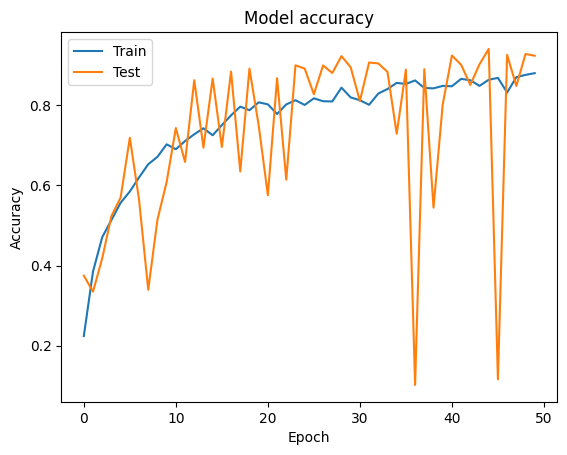

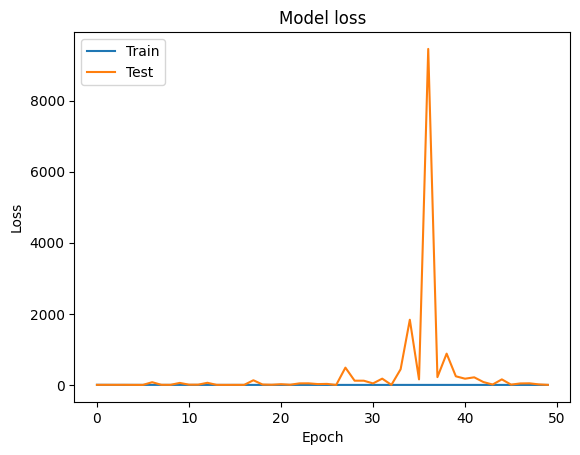

In [ ]:
# Plot training & validation accuracy values
plt.plot(ResNet_history.history['acc'])
plt.plot(ResNet_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(ResNet_history.history['loss'])
plt.plot(ResNet_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### VGG19

In [ ]:
input = keras.Input(shape=(img_size,img_size,3), name="input")
vmodel = keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=input)
vgg_model = keras.models.Sequential()
vgg_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, (img_size,img_size))))
vgg_model.add(vmodel)
vgg_model.add(keras.layers.Flatten())
vgg_model.add(keras.layers.BatchNormalization())
vgg_model.add(keras.layers.Dense(256, activation='relu'))
vgg_model.add(keras.layers.Dropout(0.5))
vgg_model.add(keras.layers.BatchNormalization())
vgg_model.add(keras.layers.Dense(128, activation='relu'))
vgg_model.add(keras.layers.Dropout(0.5))
vgg_model.add(keras.layers.BatchNormalization())
vgg_model.add(keras.layers.Dense(64, activation='relu'))
vgg_model.add(keras.layers.Dropout(0.5))
vgg_model.add(keras.layers.BatchNormalization())
vgg_model.add(keras.layers.Dense(32, activation='relu'))
vgg_model.add(keras.layers.Dropout(0.5))
vgg_model.add(keras.layers.BatchNormalization())
vgg_model.add(keras.layers.Dense(train_generator.num_classes, activation='softmax'))

vgg_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
vgg_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
VGG_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 144s 86ms/step - acc: 0.1207 - loss: 3.4524 - val_acc: 0.1657 - val_loss: 3.1017
Epoch 2/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 113s 83ms/step - acc: 0.2354 - loss: 2.7647 - val_acc: 0.0627 - val_loss: 6.7982
Epoch 3/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 113s 83ms/step - acc: 0.2685 - loss: 2.5591 - val_acc: 0.1489 - val_loss: 6183441.5000
Epoch 4/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 113s 84ms/step - acc: 0.3138 - loss: 2.3833 - val_acc: 0.0872 - val_loss: 474295712.0000
Epoch 5/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 113s 83ms/step - acc: 0.3296 - loss: 2.3137 - val_acc: 0.3874 - val_loss: 9973000192.0000
Epoch 6/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 114s 84ms/step - acc: 0.3367 - loss: 2.2868 - val_acc: 0.4565 - val_loss: 41738.6641
Epoch 7/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 114s 84ms/step - acc: 0.3427 - loss: 2.2698 - val_acc: 0.0576 - val_loss: 3.7034
Epoch 8/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 113s 83ms/step - acc: 0.3566 - loss: 2.2381 - val_acc: 0.4001 - val_lo

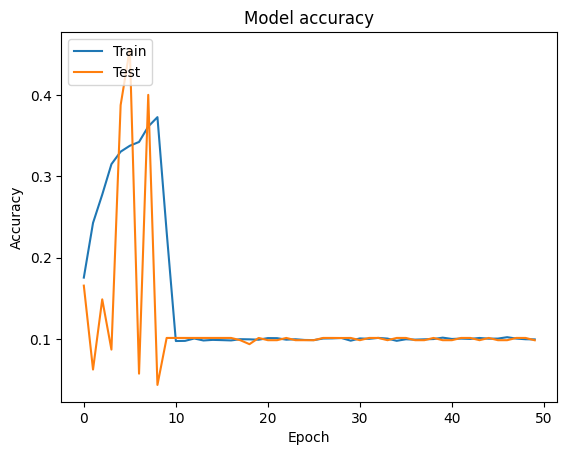

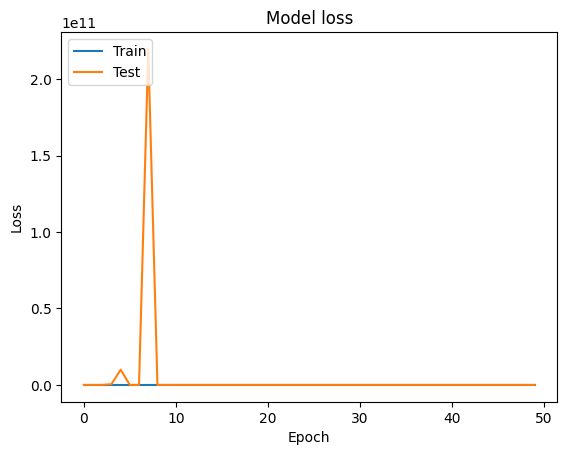

In [ ]:
# Plot training & validation accuracy values
plt.plot(VGG_history.history['acc'])
plt.plot(VGG_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(VGG_history.history['loss'])
plt.plot(VGG_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### MobileNetV2


In [ ]:
input = keras.Input(shape=(img_size,img_size,3), name="input")
m_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_tensor=input)
mobile_model = keras.models.Sequential()
mobile_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, (img_size,img_size))))
mobile_model.add(m_model)
mobile_model.add(keras.layers.Flatten())
mobile_model.add(keras.layers.BatchNormalization())
mobile_model.add(keras.layers.Dense(256, activation='relu'))
mobile_model.add(keras.layers.Dropout(0.5))
mobile_model.add(keras.layers.BatchNormalization())
mobile_model.add(keras.layers.Dense(128, activation='relu'))
mobile_model.add(keras.layers.Dropout(0.5))
mobile_model.add(keras.layers.BatchNormalization())
mobile_model.add(keras.layers.Dense(64, activation='relu'))
mobile_model.add(keras.layers.Dropout(0.5))
mobile_model.add(keras.layers.BatchNormalization())
mobile_model.add(keras.layers.Dense(train_generator.num_classes, activation='softmax'))

mobile_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
mobile_model.summary()

/tmp/ipython-input-3094547803.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  m_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_tensor=input)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [ ]:
MobileNet_history = mobile_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 158s 58ms/step - acc: 0.3845 - loss: 2.4189 - val_acc: 0.1398 - val_loss: 8.5137
Epoch 2/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 68s 50ms/step - acc: 0.7167 - loss: 0.9914 - val_acc: 0.4360 - val_loss: 2.5098
Epoch 3/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 68s 50ms/step - acc: 0.7922 - loss: 0.7138 - val_acc: 0.0501 - val_loss: 7.2912
Epoch 4/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - acc: 0.7891 - loss: 0.7301 - val_acc: 0.8208 - val_loss: 0.6759
Epoch 5/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step - acc: 0.8360 - loss: 0.5582 - val_acc: 0.7539 - val_loss: 0.8982
Epoch 6/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 70s 51ms/step - acc: 0.8656 - loss: 0.4831 - val_acc: 0.8550 - val_loss: 0.5907
Epoch 7/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - acc: 0.8810 - loss: 0.4251 - val_acc: 0.7067 - val_loss: 1.4119
Epoch 8/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - acc: 0.8823 - loss: 0.4273 - val_acc: 0.8328 - val_loss: 0.7548
Epoch 9/50
1358/1358 ━━

In [ ]:
# Plot training & validation accuracy values
plt.plot(MobileNet_history.history['acc'])
plt.plot(MobileNet_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(MobileNet_history.history['loss'])
plt.plot(MobileNet_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### EfficientNetB7

In [ ]:
input = keras.Input(shape=(img_size,img_size,3), name="input")
e_model = keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=input)
Efficient_model = keras.models.Sequential()
Efficient_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, (img_size,img_size))))
Efficient_model.add(e_model)
Efficient_model.add(keras.layers.Flatten())
Efficient_model.add(keras.layers.BatchNormalization())
Efficient_model.add(keras.layers.Dense(256, activation='relu'))
Efficient_model.add(keras.layers.Dropout(0.5))
Efficient_model.add(keras.layers.BatchNormalization())
Efficient_model.add(keras.layers.Dense(128, activation='relu'))
Efficient_model.add(keras.layers.Dropout(0.5))
Efficient_model.add(keras.layers.BatchNormalization())
Efficient_model.add(keras.layers.Dense(64, activation='relu'))
Efficient_model.add(keras.layers.Dropout(0.5))
Efficient_model.add(keras.layers.BatchNormalization())
Efficient_model.add(keras.layers.Dense(train_generator.num_classes, activation='softmax'))

Efficient_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
Efficient_model.summary()

In [ ]:
Efficient_history = Efficient_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

In [ ]:
# Plot training & validation accuracy values
plt.plot(Efficient_history.history['acc'])
plt.plot(Efficient_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Efficient_history.history['loss'])
plt.plot(Efficient_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### GoogleNet

In [ ]:
input = keras.Input(shape=(img_size, img_size, 3), name="input")
g_model = keras.applications.InceptionV3(include_top=False, weights='imagenet', input_tensor=input)
google_net_model = keras.models.Sequential()
google_net_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, (img_size, img_size))))
google_net_model.add(g_model)
google_net_model.add(keras.layers.Flatten())
google_net_model.add(keras.layers.BatchNormalization())
google_net_model.add(keras.layers.Dense(256, activation='relu'))
google_net_model.add(keras.layers.Dropout(0.5))
google_net_model.add(keras.layers.BatchNormalization())
google_net_model.add(keras.layers.Dense(128, activation='relu'))
google_net_model.add(keras.layers.Dropout(0.5))
google_net_model.add(keras.layers.BatchNormalization())
google_net_model.add(keras.layers.Dense(64, activation='relu'))
google_net_model.add(keras.layers.Dropout(0.5))
google_net_model.add(keras.layers.BatchNormalization())
google_net_model.add(keras.layers.Dense(train_generator.num_classes, activation='softmax'))

google_net_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
google_net_model.summary()

In [ ]:
GoogleNet_history = google_net_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

In [ ]:
# Plot training & validation accuracy values
plt.plot(GoogleNet_history.history['acc'])
plt.plot(GoogleNet_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(GoogleNet_history.history['loss'])
plt.plot(GoogleNet_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
image_path = r"/content/test_apple_black_rot.JPG"

predicted_class_name = predict_image_class(res_model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)
predicted_class_name = predict_image_class(vgg_model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)
predicted_class_name = predict_image_class(mobile_model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)
predicted_class_name = predict_image_class(Efficient_model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)
predicted_class_name = predict_image_class(google_net_model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class Name: Apple___Black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class Name: Orange___Haunglongbing_(Citrus_greening)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class Name: Apple___Black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class Name: Apple___Black_rot


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted Class Name: Apple___Black_rot


### Deep Learning Models

#### Model 1

In [ ]:
# Model Definition
model1 = models.Sequential()

model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model1.add(layers.MaxPooling2D(2, 2))

model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(2, 2))


model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(train_generator.num_classes, activation='softmax'))

#model compile
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model summary
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,805,158 (182.36 MB)

 Trainable params: 47,805,158 (182.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the Model
history = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=50,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 77s 52ms/step - accuracy: 0.6087 - loss: 1.7375 - val_accuracy: 0.8665 - val_loss: 0.4319
Epoch 2/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 73s 53ms/step - accuracy: 0.9217 - loss: 0.2531 - val_accuracy: 0.8842 - val_loss: 0.3988
Epoch 3/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 70s 51ms/step - accuracy: 0.9648 - loss: 0.1085 - val_accuracy: 0.8461 - val_loss: 0.5531
Epoch 4/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - accuracy: 0.9737 - loss: 0.0820 - val_accuracy: 0.8818 - val_loss: 0.5077
Epoch 5/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - accuracy: 0.9825 - loss: 0.0605 - val_accuracy: 0.8726 - val_loss: 0.5648
Epoch 6/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step - accuracy: 0.9831 - loss: 0.0536 - val_accuracy: 0.8726 - val_loss: 0.6810
Epoch 7/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - accuracy: 0.9845 - loss: 0.0509 - val_accuracy: 0.8853 - val_loss: 0.5797
Epoch 8/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - accuracy: 0.9888 - loss: 0.03

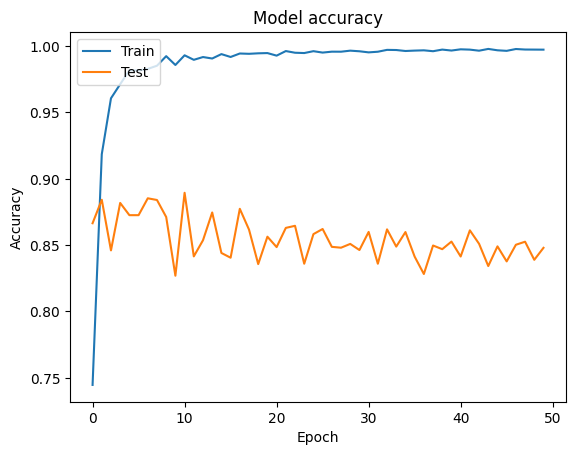

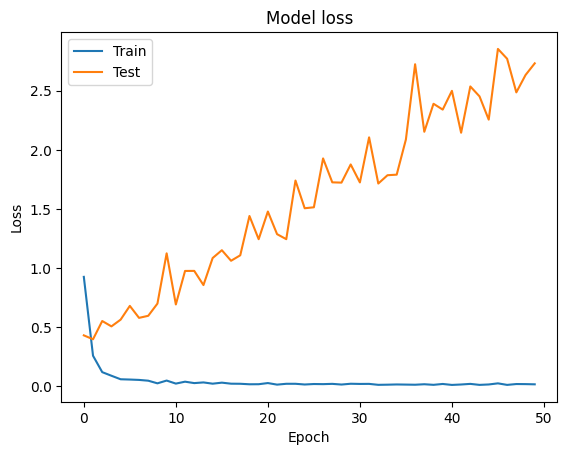

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Model 2

In [ ]:
# Model Definition
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model2.add(layers.MaxPooling2D(2, 2))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))

model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(train_generator.num_classes, activation='softmax'))

#model compile
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model summary
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,254,438 (84.89 MB)

 Trainable params: 22,254,438 (84.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the Model
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Number of steps per epoch
    epochs=50,  # Number of epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size  # Validation steps
)

Epoch 1/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 75s 53ms/step - accuracy: 0.5832 - loss: 1.5344 - val_accuracy: 0.8564 - val_loss: 0.4705
Epoch 2/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 70s 51ms/step - accuracy: 0.9003 - loss: 0.3183 - val_accuracy: 0.9010 - val_loss: 0.3253
Epoch 3/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 74s 54ms/step - accuracy: 0.9533 - loss: 0.1425 - val_accuracy: 0.9000 - val_loss: 0.3718
Epoch 4/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 73s 54ms/step - accuracy: 0.9698 - loss: 0.0918 - val_accuracy: 0.8916 - val_loss: 0.3771
Epoch 5/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - accuracy: 0.9798 - loss: 0.0648 - val_accuracy: 0.9010 - val_loss: 0.3990
Epoch 6/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - accuracy: 0.9820 - loss: 0.0585 - val_accuracy: 0.9052 - val_loss: 0.4074
Epoch 7/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 68s 50ms/step - accuracy: 0.9833 - loss: 0.0520 - val_accuracy: 0.8870 - val_loss: 0.5416
Epoch 8/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - accuracy: 0.9872 -

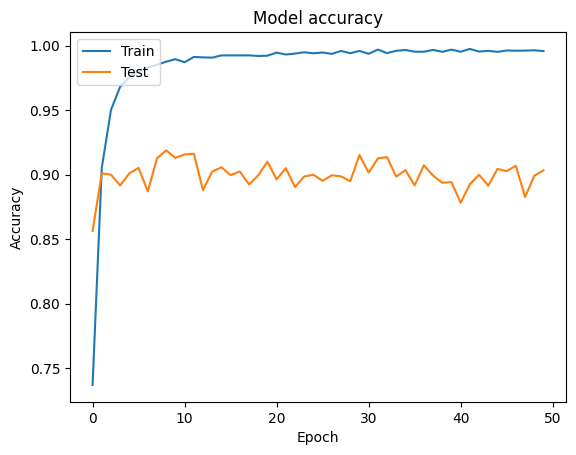

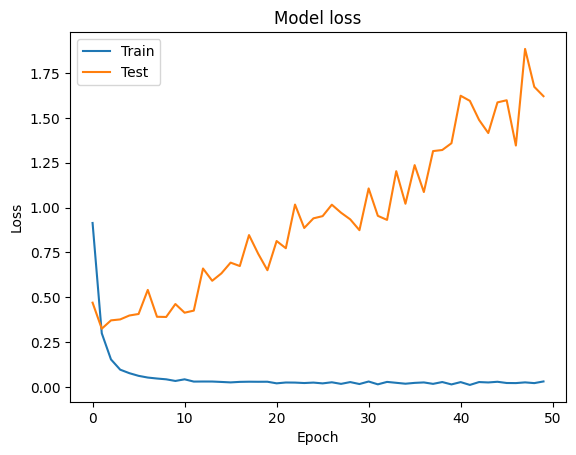

In [ ]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Model 3

In [ ]:
# Base CNN model

input = keras.Input(shape=(img_size,img_size,3), name="input")

x = keras.layers.Conv2D(32, (3,3), activation= 'relu', padding='same')(input)
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation='relu', padding= 'same')(x)
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation='relu', padding= 'same')(x)
x = keras.layers.MaxPooling2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.8)(x)

output = keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model3 = keras.Model(inputs = input, outputs = output)

model3.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
model3.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,388,326 (12.93 MB)

 Trainable params: 3,388,326 (12.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 79s 53ms/step - acc: 0.2459 - loss: 2.8497 - val_acc: 0.6766 - val_loss: 1.1973
Epoch 2/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step - acc: 0.5453 - loss: 1.5521 - val_acc: 0.7744 - val_loss: 0.7608
Epoch 3/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - acc: 0.6406 - loss: 1.1992 - val_acc: 0.8296 - val_loss: 0.5799
Epoch 4/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - acc: 0.6821 - loss: 1.0272 - val_acc: 0.8410 - val_loss: 0.5244
Epoch 5/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - acc: 0.7137 - loss: 0.9219 - val_acc: 0.8722 - val_loss: 0.4161
Epoch 6/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - acc: 0.7494 - loss: 0.7932 - val_acc: 0.8876 - val_loss: 0.3507
Epoch 7/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 72s 53ms/step - acc: 0.7730 - loss: 0.7162 - val_acc: 0.8975 - val_loss: 0.3238
Epoch 8/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 69s 51ms/step - acc: 0.7927 - loss: 0.6393 - val_acc: 0.9098 - val_loss: 0.2885
Epoch 9/50
1358/1358 ━━━

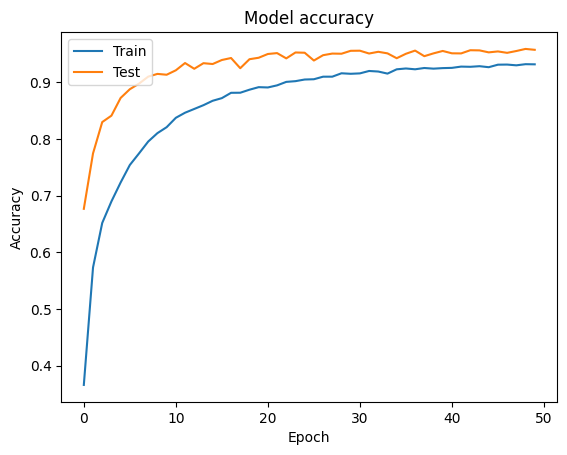

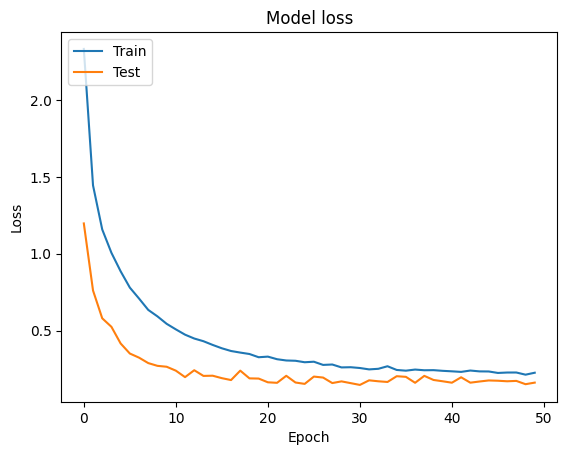

In [ ]:
# Plot training & validation accuracy values
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
image_path = r"/content/test_apple_black_rot.JPG"

predicted_class_name = predict_image_class(model1, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)
predicted_class_name = predict_image_class(model2, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)
predicted_class_name = predict_image_class(model3, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
Predicted Class Name: Apple___Black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
Predicted Class Name: Apple___Black_rot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
Predicted Class Name: Apple___Black_rot


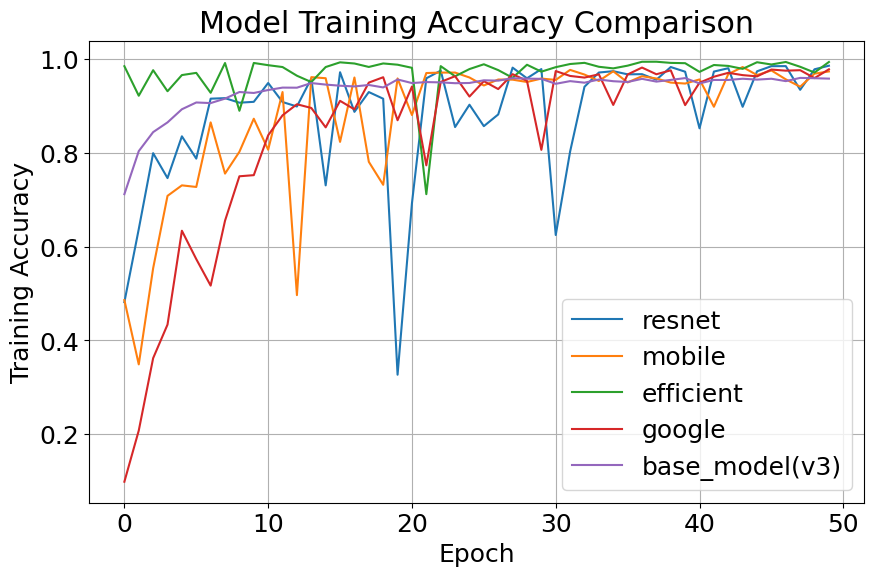

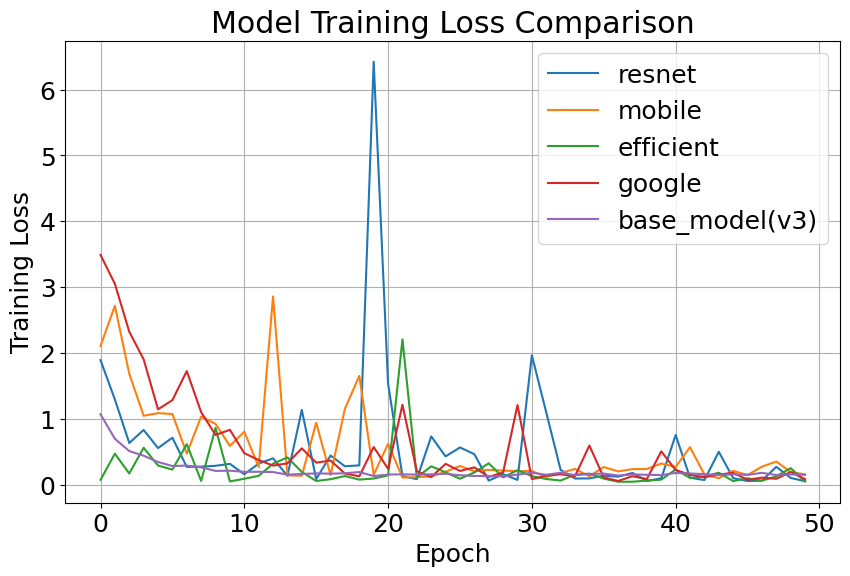

In [ ]:
# Function to compare models based on validation accuracy
def compare_models(histories, model_names):
    plt.figure(figsize=(10, 6))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_acc'] if 'accuracy' in history.history else history.history['val_acc'], label=model_names[i])
    plt.title('Model Training Accuracy Comparison')
    plt.ylabel('Training Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()


# Example usage (replace with your actual histories and names):
histories = [ResNet_history, MobileNet_history, Efficient_history, GoogleNet_history, history3]
model_names = ['resnet', 'mobile', 'efficient', 'google', 'base_model(v3)']
compare_models(histories, model_names)

# You can similarly create functions for comparing other metrics
# Like validation loss or even training accuracy
# Function to compare models based on validation loss
def compare_models_loss(histories, model_names):
    plt.figure(figsize=(10, 6))
    for i, history in enumerate(histories):
        plt.plot(history.history['val_loss'], label=model_names[i])
    plt.title('Model Training Loss Comparison')
    plt.ylabel('Training Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

compare_models_loss(histories, model_names)


In [ ]:
epochs = range(1, len(ResNet_history.history['loss']) + 1)

# Create subplots: One for loss, one for accuracy
fig, axes = plt.subplots(11, 2, figsize= (50,100))
plt.rcParams.update({'font.size': 18})

# Plot Loss Curves
axes[0,0].plot(epochs, history.history['loss'], label="Base model (v1) - Train Loss", linestyle='-', marker='o')
axes[0,0].plot(epochs, history.history['val_loss'], label="Base model (v1) - Val Loss", linestyle='--', marker='s')
axes[0,0].set_title("Base model (v1) Loss over Epochs")
axes[0,0].set_xlabel("Epochs")
axes[0,0].set_ylabel("Loss")
axes[0,0].legend()
axes[0,0].grid(True)

# Plot Accuracy Curves
axes[0,1].plot(epochs, history.history['accuracy'], label="Base model (v1) - Train Accuracy", linestyle='-', marker='o')
axes[0,1].plot(epochs, history.history['val_accuracy'], label="Base model (v1) - Val Accuracy", linestyle='--', marker='s')
axes[0,1].set_title("Base model (v1) Accuracy over Epochs")
axes[0,1].set_xlabel("Epochs")
axes[0,1].set_ylabel("Accuracy")
axes[0,1].legend()
axes[0,1].grid(True)

# Plot Loss Curves
axes[1,0].plot(epochs, history2.history['loss'], label="Base model (v2) - Train Loss", linestyle='-', marker='o')
axes[1,0].plot(epochs, history2.history['val_loss'], label="Base model (v2) - Val Loss", linestyle='--', marker='s')
axes[1,0].set_title("Base model (v2) Loss over Epochs")
axes[1,0].set_xlabel("Epochs")
axes[1,0].set_ylabel("Loss")
axes[1,0].legend()
axes[1,0].grid(True)

# Plot Accuracy Curves
axes[1,1].plot(epochs, history2.history['accuracy'], label="Base model (v2) - Train Accuracy", linestyle='-', marker='o')
axes[1,1].plot(epochs, history2.history['val_accuracy'], label="Base model (v2) - Val Accuracy", linestyle='--', marker='s')
axes[1,1].set_title("Base model (v2) Accuracy over Epochs")
axes[1,1].set_xlabel("Epochs")
axes[1,1].set_ylabel("Accuracy")
axes[1,1].legend()
axes[1,1].grid(True)

# Plot Loss Curves
axes[2,0].plot(epochs, history3.history['loss'], label="Base model (v3) - Train Loss", linestyle='-', marker='o')
axes[2,0].plot(epochs, history3.history['val_loss'], label="Base model (v3) - Val Loss", linestyle='--', marker='s')
axes[2,0].set_title("Base model (v3) Loss over Epochs")
axes[2,0].set_xlabel("Epochs")
axes[2,0].set_ylabel("Loss")
axes[2,0].legend()
axes[2,0].grid(True)

# Plot Accuracy Curves
axes[2,1].plot(epochs, history3.history['acc'], label="Base model (v3) - Train Accuracy", linestyle='-', marker='o')
axes[2,1].plot(epochs, history3.history['val_acc'], label="Base model (v3) - Val Accuracy", linestyle='--', marker='s')
axes[2,1].set_title("Base model (v3) Accuracy over Epochs")
axes[2,1].set_xlabel("Epochs")
axes[2,1].set_ylabel("Accuracy")
axes[2,1].legend()
axes[2,1].grid(True)

# Plot Loss Curves
axes[3,0].plot(epochs, ResNet_history.history['loss'], label="ResNet50 - Train Loss", linestyle='-', marker='o')
axes[3,0].plot(epochs, ResNet_history.history['val_loss'], label="ResNet50 - Val Loss", linestyle='--', marker='s')
axes[3,0].set_title("ResNet50 Loss over Epochs")
axes[3,0].set_xlabel("Epochs")
axes[3,0].set_ylabel("Loss")
axes[3,0].legend()
axes[3,0].grid(True)

# Plot Accuracy Curves
axes[3,1].plot(epochs, ResNet_history.history['acc'], label="ResNet50 - Train Accuracy", linestyle='-', marker='o')
axes[3,1].plot(epochs, ResNet_history.history['val_acc'], label="ResNet50 - Val Accuracy", linestyle='--', marker='s')
axes[3,1].set_title("ResNet50 Accuracy over Epochs")
axes[3,1].set_xlabel("Epochs")
axes[3,1].set_ylabel("Accuracy")
axes[3,1].legend()
axes[3,1].grid(True)

# Plot Loss Curves
axes[4,0].plot(epochs, MobileNet_history.history['loss'], label="MobileNetV2 - Train Loss", linestyle='-', marker='o')
axes[4,0].plot(epochs, MobileNet_history.history['val_loss'], label="MobileNetV2 - Val Loss", linestyle='--', marker='s')
axes[4,0].set_title("MobileNetV2 Loss over Epochs")
axes[4,0].set_xlabel("Epochs")
axes[4,0].set_ylabel("Loss")
axes[4,0].legend()
axes[4,0].grid(True)

# Plot Accuracy Curves
axes[4,1].plot(epochs, MobileNet_history.history['acc'], label="MobileNetV2 - Train Accuracy", linestyle='-', marker='o')
axes[4,1].plot(epochs, MobileNet_history.history['val_acc'], label="MobileNetV2 - Val Accuracy", linestyle='--', marker='s')
axes[4,1].set_title("MobileNetV2 Accuracy over Epochs")
axes[4,1].set_xlabel("Epochs")
axes[4,1].set_ylabel("Accuracy")
axes[4,1].legend()
axes[4,1].grid(True)


# Plot Loss Curves
axes[5,0].plot(epochs, Efficient_history.history['loss'], label="EfficientNetB7 - Train Loss", linestyle='-', marker='o')
axes[5,0].plot(epochs, Efficient_history.history['val_loss'], label="EfficientNetB7 - Val Loss", linestyle='--', marker='s')
axes[5,0].set_title("EfficientNetB7 Loss over Epochs")
axes[5,0].set_xlabel("Epochs")
axes[5,0].set_ylabel("Loss")
axes[5,0].legend()
axes[5,0].grid(True)

# Plot Accuracy Curves
axes[5,1].plot(epochs, Efficient_history.history['acc'], label="EfficientNetB7 - Train Accuracy", linestyle='-', marker='o')
axes[5,1].plot(epochs, Efficient_history.history['val_acc'], label="EfficientNetB7 - Val Accuracy", linestyle='--', marker='s')
axes[5,1].set_title("EfficientNetB7 Accuracy over Epochs")
axes[5,1].set_xlabel("Epochs")
axes[5,1].set_ylabel("Accuracy")
axes[5,1].legend()
axes[5,1].grid(True)

# Plot Loss Curves
axes[6,0].plot(epochs, GoogleNet_history.history['loss'], label="GoogleNet - Train Loss", linestyle='-', marker='o')
axes[6,0].plot(epochs, GoogleNet_history.history['val_loss'], label="GoogleNet - Val Loss", linestyle='--', marker='s')
axes[6,0].set_title("GoogleNet Loss over Epochs")
axes[6,0].set_xlabel("Epochs")
axes[6,0].set_ylabel("Loss")
axes[6,0].legend()
axes[6,0].grid(True)

# Plot Accuracy Curves
axes[6,1].plot(epochs, GoogleNet_history.history['acc'], label="GoogleNet - Train Accuracy", linestyle='-', marker='o')
axes[6,1].plot(epochs, GoogleNet_history.history['val_acc'], label="GoogleNet - Val Accuracy", linestyle='--', marker='s')
axes[6,1].set_title("GoogleNet Accuracy over Epochs")
axes[6,1].set_xlabel("Epochs")
axes[6,1].set_ylabel("Accuracy")
axes[6,1].legend()
axes[6,1].grid(True)

# Plot Loss Curves
axes[7,0].plot(epochs, VGG_history.history['loss'], label="VGG19 - Train Loss", linestyle='-', marker='o')
axes[7,0].plot(epochs, VGG_history.history['val_loss'], label="VGG19 - Val Loss", linestyle='--', marker='s')
axes[7,0].set_title("VGG19 Loss over Epochs")
axes[7,0].set_xlabel("Epochs")
axes[7,0].set_ylabel("Loss")
axes[7,0].legend()
axes[7,0].grid(True)

# Plot Accuracy Curves
axes[7,1].plot(epochs, VGG_history.history['acc'], label="VGG19 - Train Accuracy", linestyle='-', marker='o')
axes[7,1].plot(epochs, VGG_history.history['val_acc'], label="VGG19 - Val Accuracy", linestyle='--', marker='s')
axes[7,1].set_title("VGG19 Accuracy over Epochs")
axes[7,1].set_xlabel("Epochs")
axes[7,1].set_ylabel("Accuracy")
axes[7,1].legend()
axes[7,1].grid(True)

# Plot Loss Curves
axes[8,0].plot(epochs, VGG_history.history['loss'], label="VGG19 - Train Loss", linestyle='--', marker='o')
axes[8,0].plot(epochs, ResNet_history.history['loss'], label="ResNet - Train Loss", linestyle='--', marker='s')
axes[8,0].plot(epochs, Efficient_history.history['loss'], label="Efficient - Train Loss", linestyle='--', marker='^')
axes[8,0].plot(epochs, MobileNet_history.history['loss'], label="MobileNet - Train Loss", linestyle='--', marker='*')
axes[8,0].plot(epochs, GoogleNet_history.history['loss'], label="GoogleNet - Train Loss", linestyle='--', marker='+')
axes[8,0].plot(epochs, history.history['loss'], label="Base model (v1) - Train Loss", linestyle='--', marker='p')
axes[8,0].plot(epochs, history2.history['loss'], label="Base model (v2) - Train Loss", linestyle='--', marker='v')
axes[8,0].plot(epochs, history3.history['loss'], label="Base model (v3) - Train Loss", linestyle='--', marker='8')
axes[8,0].set_title("Comparison of Loss over Epochs")
axes[8,0].set_xlabel("Epochs")
axes[8,0].set_ylabel("Loss")
axes[8,0].legend()
axes[8,0].grid(True)

# Plot Accuracy Curves
axes[8,1].plot(epochs, VGG_history.history['acc'], label="VGG19 - Train accuracy", linestyle='--', marker='o')
axes[8,1].plot(epochs, ResNet_history.history['acc'], label="ResNet - Train accuracy", linestyle='--', marker='s')
axes[8,1].plot(epochs, Efficient_history.history['acc'], label="Efficient - Train accuracy", linestyle='--', marker='^')
axes[8,1].plot(epochs, MobileNet_history.history['acc'], label="MobileNet - Train accuracy", linestyle='--', marker='*')
axes[8,1].plot(epochs, GoogleNet_history.history['acc'], label="GoogleNet - Train accuracy", linestyle='--', marker='+')
axes[8,1].plot(epochs, history.history['accuracy'], label="Base model (v1) - Train Loss", linestyle='--', marker='p')
axes[8,1].plot(epochs, history2.history['accuracy'], label="Base model (v2) - Train Loss", linestyle='--', marker='v')
axes[8,1].plot(epochs, history3.history['acc'], label="Base model (v3) - Train Loss", linestyle='--', marker='8')
axes[8,1].set_title("Comparison of Accuracy over Epochs")
axes[8,1].set_xlabel("Epochs")
axes[8,1].set_ylabel("Accuracy")
axes[8,1].legend()
axes[8,1].grid(True)

# Plot Loss Curves
axes[9,0].plot(epochs, VGG_history.history['val_loss'], label="VGG19 - Validation Loss", linestyle='--', marker='o')
axes[9,0].plot(epochs, ResNet_history.history['val_loss'], label="ResNet - Validation Loss", linestyle='--', marker='s')
axes[9,0].plot(epochs, Efficient_history.history['val_loss'], label="Efficient - Validation Loss", linestyle='--', marker='^')
axes[9,0].plot(epochs, MobileNet_history.history['val_loss'], label="MobileNet - Validation Loss", linestyle='--', marker='*')
axes[9,0].plot(epochs, GoogleNet_history.history['val_loss'], label="GoogleNet - validation Loss", linestyle='--', marker='+')
axes[9,0].plot(epochs, history.history['val_loss'], label="Base model (v1) - validation Loss", linestyle='--', marker='p')
axes[9,0].plot(epochs, history2.history['val_loss'], label="Base model (v2) - validation Loss", linestyle='--', marker='v')
axes[9,0].plot(epochs, history3.history['val_loss'], label="Base model (v3) - validation Loss", linestyle='--', marker='8')
axes[9,0].set_title("Comparison of Validation Loss over Epochs")
axes[9,0].set_xlabel("Epochs")
axes[9,0].set_ylabel("Loss")
axes[9,0].legend()
axes[9,0].grid(True)

# Plot Accuracy Curves
axes[9,1].plot(epochs, VGG_history.history['val_acc'], label="VGG19 - Validation accuracy", linestyle='--', marker='o')
axes[9,1].plot(epochs, ResNet_history.history['val_acc'], label="ResNet - Validation accuracy", linestyle='--', marker='s')
axes[9,1].plot(epochs, Efficient_history.history['val_acc'], label="Efficient - Validation accuracy", linestyle='--', marker='^')
axes[9,1].plot(epochs, MobileNet_history.history['val_acc'], label="MobileNet - Validation accuracy", linestyle='--', marker='*')
axes[9,1].plot(epochs, GoogleNet_history.history['val_acc'], label="GoogleNet - Validation accuracy", linestyle='--', marker='+')
axes[9,1].plot(epochs, history.history['val_accuracy'], label="Base model (v1) - Validation accuracy", linestyle='--', marker='p')
axes[9,1].plot(epochs, history2.history['val_accuracy'], label="Base model (v2) - Validation accuracy", linestyle='--', marker='v')
axes[9,1].plot(epochs, history3.history['val_acc'], label="Base model (v3) - Validation accuracy", linestyle='--', marker='8')
axes[9,1].set_title("Comparison of Validation Accuracy over Epochs")
axes[9,1].set_xlabel("Epochs")
axes[9,1].set_ylabel("Accuracy")
axes[9,1].legend()
axes[9,1].grid(True)


# Plot Loss Curves
#axes[9,0].plot(epochs, VGG_history.history['val_loss'], label="VGG19 - Validation Loss", linestyle='--', marker='o')
axes[10,0].plot(epochs, ResNet_history.history['val_loss'], label="ResNet - Validation Loss", linestyle='--', marker='s')
axes[10,0].plot(epochs, Efficient_history.history['val_loss'], label="Efficient - Validation Loss", linestyle='--', marker='^')
axes[10,0].plot(epochs, MobileNet_history.history['val_loss'], label="MobileNet - Validation Loss", linestyle='--', marker='*')
axes[10,0].plot(epochs, GoogleNet_history.history['val_loss'], label="GoogleNet - validation Loss", linestyle='--', marker='+')
axes[10,0].plot(epochs, history.history['val_loss'], label="Base model (v1) - validation Loss", linestyle='--', marker='p')
axes[10,0].plot(epochs, history2.history['val_loss'], label="Base model (v2) - validation Loss", linestyle='--', marker='v')
axes[10,0].plot(epochs, history3.history['val_loss'], label="Base model (v3) - validation Loss", linestyle='--', marker='8')
axes[10,0].set_title("Comparison of Validation Loss over Epochs")
axes[10,0].set_xlabel("Epochs")
axes[10,0].set_ylabel("Loss")
axes[10,0].legend()
axes[10,0].grid(True)

# Plot Accuracy Curves
#axes[9,1].plot(epochs, VGG_history.history['val_acc'], label="VGG19 - Validation accuracy", linestyle='--', marker='o')
axes[10,1].plot(epochs, ResNet_history.history['val_acc'], label="ResNet - Validation accuracy", linestyle='--', marker='s')
axes[10,1].plot(epochs, Efficient_history.history['val_acc'], label="Efficient - Validation accuracy", linestyle='--', marker='^')
axes[10,1].plot(epochs, MobileNet_history.history['val_acc'], label="MobileNet - Validation accuracy", linestyle='--', marker='*')
axes[10,1].plot(epochs, GoogleNet_history.history['val_acc'], label="GoogleNet - Validation accuracy", linestyle='--', marker='+')
axes[10,1].plot(epochs, history.history['val_accuracy'], label="Base model (v1) - Validation accuracy", linestyle='--', marker='p')
axes[10,1].plot(epochs, history2.history['val_accuracy'], label="Base model (v2) - Validation accuracy", linestyle='--', marker='v')
axes[10,1].plot(epochs, history3.history['val_acc'], label="Base model (v3) - Validation accuracy", linestyle='--', marker='8')
axes[10,1].set_title("Comparison of Validation Accuracy over Epochs")
axes[10,1].set_xlabel("Epochs")
axes[10,1].set_ylabel("Accuracy")
axes[10,1].legend()
axes[10,1].grid(True)

Output hidden; open in https://colab.research.google.com to view.

### Base Model


#### ResNet

In [ ]:
input = keras.Input(shape=(img_size,img_size,3), name="input")
rmodel = keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=input)
res_base_model = keras.models.Sequential()
res_base_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, (img_size,img_size))))
res_base_model.add(rmodel)
res_base_model.add(keras.layers.GlobalAveragePooling2D())
res_base_model.add(keras.layers.Dense(train_generator.num_classes, activation='softmax'))

res_base_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
res_base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
ResNet_history = res_base_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 147s 65ms/step - acc: 0.8307 - loss: 0.6151 - val_acc: 0.6763 - val_loss: 1.4981
Epoch 2/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 85s 63ms/step - acc: 0.9618 - loss: 0.1155 - val_acc: 0.8999 - val_loss: 0.3591
Epoch 3/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 86s 63ms/step - acc: 0.9756 - loss: 0.0750 - val_acc: 0.8822 - val_loss: 0.3952
Epoch 4/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 86s 63ms/step - acc: 0.9785 - loss: 0.0618 - val_acc: 0.7740 - val_loss: 0.9829
Epoch 5/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 86s 63ms/step - acc: 0.9859 - loss: 0.0428 - val_acc: 0.9542 - val_loss: 0.1537
Epoch 6/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 85s 62ms/step - acc: 0.9890 - loss: 0.0326 - val_acc: 0.6750 - val_loss: 1.7533
Epoch 7/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 85s 63ms/step - acc: 0.9873 - loss: 0.0354 - val_acc: 0.9217 - val_loss: 0.3806
Epoch 8/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 86s 63ms/step - acc: 0.9907 - loss: 0.0293 - val_acc: 0.8835 - val_loss: 0.4330
Epoch 9/50
1358/1358 ━━━━━━━━━━━━━

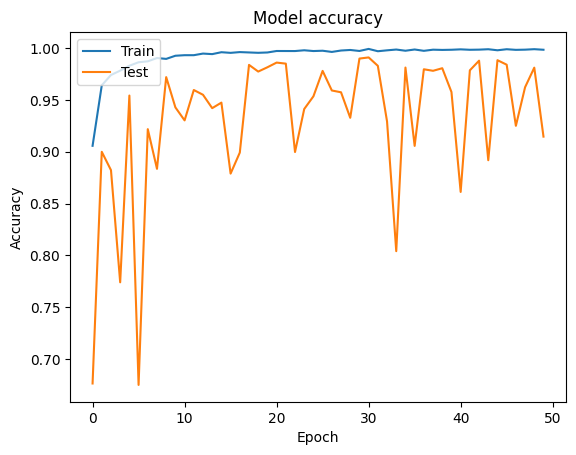

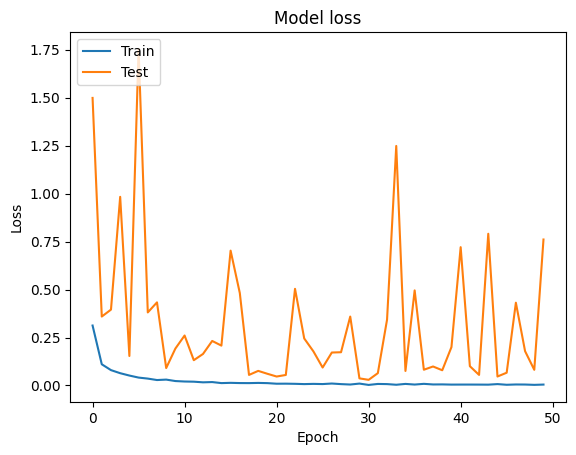

In [ ]:
# Plot training & validation accuracy values
plt.plot(ResNet_history.history['acc'])
plt.plot(ResNet_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(ResNet_history.history['loss'])
plt.plot(ResNet_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### GoogleNet


In [ ]:
input = keras.Input(shape=(img_size, img_size, 3), name="input")
g_model = keras.applications.InceptionV3(include_top=False, weights='imagenet', input_tensor=input)
google_base_model = keras.models.Sequential()
google_base_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, (img_size, img_size))))
google_base_model.add(g_model)
google_base_model.add(keras.layers.GlobalAveragePooling2D())
google_base_model.add(keras.layers.Dense(train_generator.num_classes, activation='softmax'))

google_base_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
google_base_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
GN_history = google_base_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 152s 59ms/step - acc: 0.8066 - loss: 0.6807 - val_acc: 0.6204 - val_loss: 1.9987
Epoch 2/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 75s 55ms/step - acc: 0.9527 - loss: 0.1493 - val_acc: 0.9469 - val_loss: 0.1603
Epoch 3/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 75s 55ms/step - acc: 0.9691 - loss: 0.0983 - val_acc: 0.9417 - val_loss: 0.2034
Epoch 4/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 77s 56ms/step - acc: 0.9727 - loss: 0.0844 - val_acc: 0.8790 - val_loss: 0.4263
Epoch 5/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 77s 57ms/step - acc: 0.9763 - loss: 0.0736 - val_acc: 0.8590 - val_loss: 0.4931
Epoch 6/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 78s 57ms/step - acc: 0.9813 - loss: 0.0559 - val_acc: 0.9039 - val_loss: 0.3699
Epoch 7/50
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 77s 57ms/step - acc: 0.9850 - loss: 0.0496 - val_acc: 0.9673 - val_loss: 0.1036
Epoch 8/50
1227/1358 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - acc: 0.9896 - loss: 0.0321

#### MobileNet

In [ ]:
input = keras.Input(shape=(img_size,img_size,3), name="input")
m_model = keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_tensor=input)
mobile_model = keras.models.Sequential()
mobile_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, (img_size,img_size))))
mobile_model.add(m_model)
mobile_model.add(keras.layers.GlobalAveragePooling2D())
mobile_model.add(keras.layers.Dense(train_generator.num_classes, activation='softmax'))

mobile_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
mobile_model.summary()

In [ ]:
MobileNet_history = mobile_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

#### EfficientNet

In [ ]:
input = keras.Input(shape=(img_size,img_size,3), name="input")
e_model = keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_tensor=input)
Eff_model = keras.models.Sequential()
Eff_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, (img_size,img_size))))
Eff_model.add(e_model)
Eff_model.add(keras.layers.GlobalAveragePooling2D())
Eff_model.add(keras.layers.Dense(train_generator.num_classes, activation='softmax'))

Eff_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
Eff_model.summary()

In [ ]:
Eff_history = Eff_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

#### VGG


In [ ]:
input = keras.Input(shape=(img_size,img_size,3), name="input")
vmodel = keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=input)
vgg_model = keras.models.Sequential()
vgg_model.add(keras.layers.Lambda(lambda x: tf.image.resize(x, (img_size,img_size))))
vgg_model.add(vmodel)
vgg_model.add(keras.layers.GlobalAveragePooling2D())
vgg_model.add(keras.layers.Dense(train_generator.num_classes, activation='softmax'))

vgg_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
vgg_model.summary()

In [ ]:
VGG_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples //batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

### CNN Graphs

In [ ]:
import numpy as np
from math import ceil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf

# Assume 'model' is your trained CNN model.
# Assume 'test_generator' is your test data generator created with ImageDataGenerator.flow_from_directory, e.g.:
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(img_size, img_size),
#     batch_size=32,
#     class_mode="categorical",
#     shuffle=False  # Important: keep order for evaluation!
# )

# Calculate the number of steps needed for full evaluation:
steps = ceil(test_generator.samples / test_generator.batch_size)

# Get predictions for the entire test dataset
y_pred_prob = model1.predict(test_generator, steps=steps)

# Convert predicted probabilities to class indices.
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true labels from the generator.
# Note: test_generator.classes gives the integer labels for each sample.
y_true = test_generator.classes

# Calculate metrics using scikit-learn
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Print out the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


340/340 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step
Accuracy: 0.8480
Precision: 0.8578
Recall: 0.8480
F1 Score: 0.8479

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.78      0.49      0.60       126
                                 Apple___Black_rot       0.86      0.78      0.82       124
                          Apple___Cedar_apple_rust       0.86      0.44      0.58        55
                                   Apple___healthy       0.63      0.89      0.74       329
                               Blueberry___healthy       0.86      0.94      0.90       300
          Cherry_(including_sour)___Powdery_mildew       0.89      0.88      0.89       210
                 Cherry_(including_sour)___healthy       0.93      0.72      0.81       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.66      0.59      0.62       102
                       Corn_(maize)__

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Generate the classification report as a dictionary
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=list(test_generator.class_indices.keys()),
    output_dict=True
)

# Convert the dictionary to a DataFrame and transpose it
df_report = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to a CSV file
df_report.to_csv('model1  classification_report.csv', index=True)

print("Classification report saved to 'classification_report.csv'")


Classification report saved to 'classification_report.csv'


Index(['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'], dtype='object')


<Figure size 1000x2000 with 0 Axes>

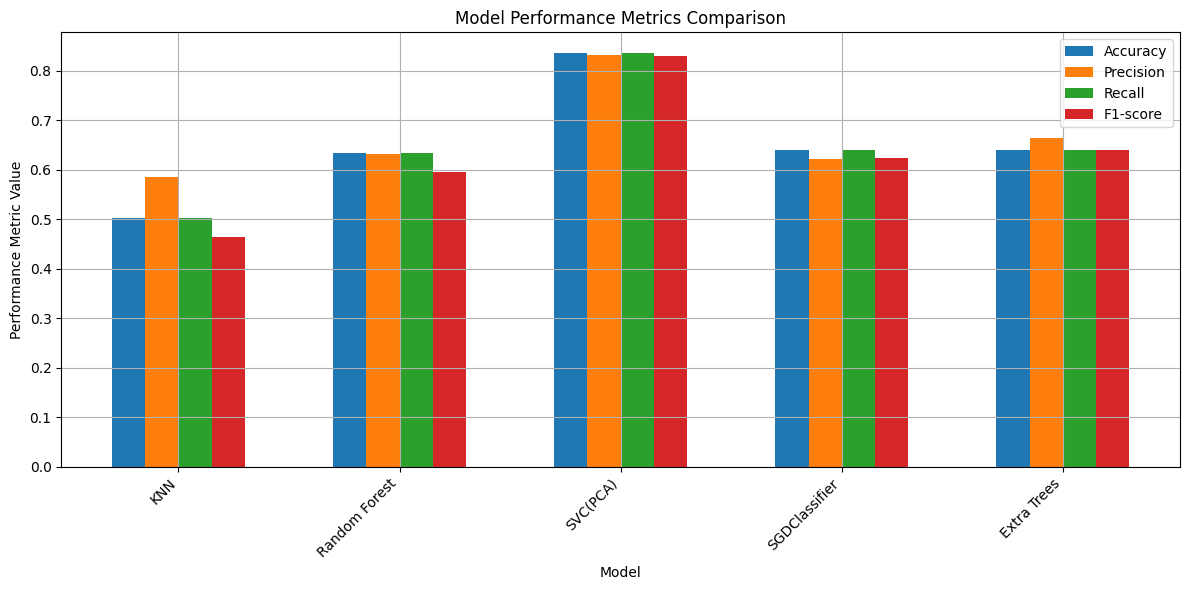

In [ ]:
0.# prompt: use /content/model performance metrics comparison .csv and plot a bar graph comparison for all

import pandas as pd
import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(20)


# Load the CSV file into a pandas DataFrame.

df = pd.read_csv('/content/ML model performance metrics comparison.csv')
print(df.columns)

# Extract the model names and performance metrics for plotting.
models = df['Model']
accuracy = df['Accuracy']
precision = df['Precision']
recall = df['Recall']
f1_score = df['F1-Score']

# Create a bar graph comparing the performance metrics for all models.
bar_width = 0.15
index = range(len(models))

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar([x - 1.5*bar_width for x in index], accuracy, bar_width, label='Accuracy')
ax.bar([x - 0.5*bar_width for x in index], precision, bar_width, label='Precision')
ax.bar([x + 0.5*bar_width for x in index], recall, bar_width, label='Recall')
ax.bar([x + 1.5*bar_width for x in index], f1_score, bar_width, label='F1-score')


ax.set_xlabel('Model')
ax.set_ylabel('Performance Metric Value')
ax.set_title('Model Performance Metrics Comparison')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45, ha='right') # Rotate x-axis labels for readability
ax.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid()
plt.show()


Index(['Model ', 'Accuracy', 'Precision ', 'Recall ', 'F1-Score'], dtype='object')


<Figure size 1000x2000 with 0 Axes>

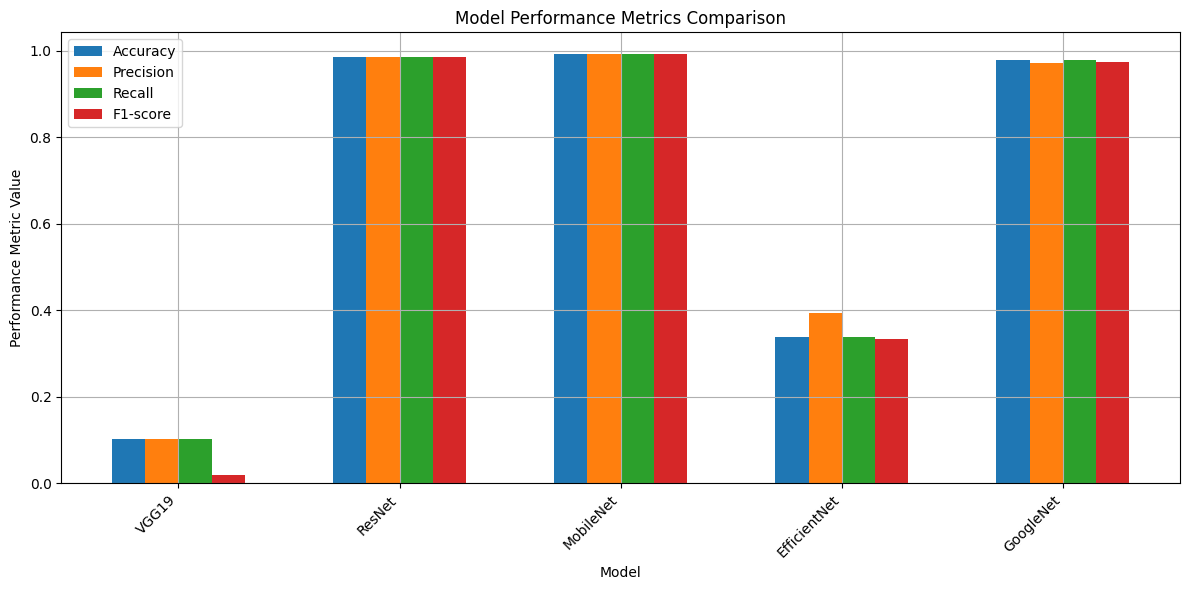

In [ ]:
# prompt: use /content/model performance metrics comparison .csv and plot a bar graph comparison for all

import pandas as pd
import matplotlib.pyplot as plt

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(20)


# Load the CSV file into a pandas DataFrame.

df = pd.read_csv('/content/model performance metrics comparison .csv')
print(df.columns)

# Extract the model names and performance metrics for plotting.
models = df['Model ']
accuracy = df['Accuracy']
precision = df['Precision ']
recall = df['Recall ']
f1_score = df['F1-Score']

# Create a bar graph comparing the performance metrics for all models.
bar_width = 0.15
index = range(len(models))

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar([x - 1.5*bar_width for x in index], accuracy, bar_width, label='Accuracy')
ax.bar([x - 0.5*bar_width for x in index], precision, bar_width, label='Precision')
ax.bar([x + 0.5*bar_width for x in index], recall, bar_width, label='Recall')
ax.bar([x + 1.5*bar_width for x in index], f1_score, bar_width, label='F1-score')


ax.set_xlabel('Model')
ax.set_ylabel('Performance Metric Value')
ax.set_title('Model Performance Metrics Comparison')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45, ha='right') # Rotate x-axis labels for readability
ax.legend()
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid()
plt.show()
